<a href="https://colab.research.google.com/github/HydroinformaticsLab/ColabWorkshop/blob/master/ExeciseHiLabML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Gerald Augusto Corzo 
Practice Colab, IHE Delft 2020 - 07- 25
Session 2

# Exercise 1

Reding rainfall data from different sources

1. Read Era5 raster data from API
2. From Gdrive
3. Using google earth engine 




<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1d79vtB9U2tsbCLdKom7oU_Hr1WhkPbqs#scrollTo=uyZ6I6WGoCAx"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/HydroinformaticsLab/ColabWorkshop/blob/master/ExeciseHiLabML1.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [16]:
#@title Magic tools for jupyter notebook
%%html
<marquee style='width: 50%; color: blue;'><b>Welcome to Hydroinformatics Lab session</b></marquee>
<br>

#@markdown To be able to load any jupyter extension %load_ext

#@markdown To be able to use Jupyter Magic features just use %%

## 1) Reading Era5 Reanalysis data


We would like to analyze the time series data from 

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview




#### Seeting up the environment

We will use the API from the copernicus climate website, please register. And look for the API information and the process to register the API on your local machien (key and url).

https://cds.climate.copernicus.eu/api-how-to


You need to register and obtain the two parameters below 

In [0]:
#!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
#!echo "key: 18475:0918427e-3da7-45da-991c-161d92b9b707" >> $HOME/.cdsapirc
#!pip install cdsapi
[-87.60483030714467,13.402246848143117]
[-86.62704710401967,13.402246848143117]
[-86.62704710401967,13.925339395097156]
[-87.60483030714467,13.925339395097156]
[-87.60483030714467,13.402246848143117]

To map the region where the rain is falling we are going to select the 



!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc


!echo "key: 18475:0918427e-3da7-45da-991c-161d92b9b707" >> $HOME/.cdsapirc

In [12]:
import cdsapi
import xarray as xr
product = 'reanalysis-era5-single-levels'
request = {'product_type': 'reanalysis',
           'format': 'netcdf',
           'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
                   '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
                   '22', '23', '24', '25', ' 26', '27', '28', '29', '30', '31'],
           'time': ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00',
                    '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00',
                    '20:00', '21:00', '22:00', '23:00'],
           'area': [-87.66, -87.65, 13.4, 13.92],
           'year': 2016,
           'month': 1,
           'variable': ['100m_u_component_of_wind',
                        '100m_v_component_of_wind',
                        '2m_temperature',
                        'runoff',
                        'soil_temperature_level_4',
                        'surface_net_solar_radiation',
                        'surface_pressure',
                        'surface_solar_radiation_downwards',
                        'toa_incident_solar_radiation',
                        'total_sky_direct_solar_radiation_at_surface']}

result = cdsapi.Client().retrieve(
    product,
    request
)

result.download("test.nc")

ds = xr.open_dataset("test.nc")
ds['ro'].to_series().describe()

2020-05-25 09:11:55,475 INFO Welcome to the CDS
2020-05-25 09:11:55,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-05-25 09:11:56,590 INFO Request is queued
2020-05-25 09:11:57,846 INFO Request is running
2020-05-25 09:20:20,298 INFO Request is completed
2020-05-25 09:20:20,302 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1590397916.6492705-14884-19-52c9b005-bc81-414c-9ce5-6f4345fbd108.nc to test.nc (377.6M)
2020-05-25 09:21:40,161 INFO Download rate 4.7M/s


count    1.979561e+07
mean     1.617490e-05
std      6.164426e-05
min     -4.656613e-10
25%     -4.656613e-10
50%      3.972091e-07
75%      1.391862e-05
max      1.303101e-02
Name: ro, dtype: float64

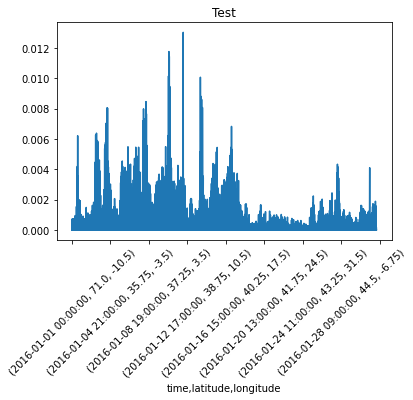

In [18]:
import matplotlib.pyplot as plt

ds['ro'].to_series().plot(title="Test",rot=45 )


### Google earth engine catalog


https://developers.google.com/earth-engine/datasets/catalog

https://code.earthengine.google.com/?scriptPath=Examples%3ADatasets%2FECMWF_ERA5_DAILY


### Short practice in Google earth
For this exercise we will select precipitation data. Google earth provide a large variety of data from different sources. Lest select daily aggregates from Era5 <https://developers.google.com/earth-engine/datasets/tags/precipitation>.





## 2) Reading data from Google earth

### Authenticating google colab 

This is needed when you run the jupyter notebook from your own terminal 

In [0]:
from google.colab import auth
auth.authenticate_user()

### Authenticating Google Earth Engine (GEE)

Google requires the authentication for each cloud service you would like to use. In this case, the library brings its own authentication procedure.

In [2]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=TMm8CdDhHw3Zr6ZOIwYphlzjZiw3baWXp9GxnczPvhc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/0AFeXaaQbRUOqrNdYW9ILupQbkM7-YHzbaEj5s7Nv8gDlK74UZV9rCY

Successfully saved authorization token.


### Library for visualization of maps
To be able to see a map in google colab you need to have a complementary library. Folium allows to use google earth engine data and plot it as if it was the google platform of Earth Engine.



In [0]:
import folium
print(folium.__version__)

0.8.3


In [0]:
#For part 1 our target is to access a database and to make a visualization of the data.

In [0]:
# Your Earth Engine username.  This is used to import a classified image
# into your Earth Engine assets folder.
USER_NAME = 'username'

# Cloud Storage bucket into which training, testing and prediction 
# datasets will be written.  You must be able to write into this bucket.
OUTPUT_BUCKET = 'HI store'

PEra5=ee.ImageCollection("ECMWF/ERA5/DAILY")
BandPEra = ['total_precipitation', 'maximum_2m_air_temperature', 'B4', 'B5', 'B6', 'B7']

# Use Landsat 8 surface reflectance data for predictors.
L8SR = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
# Use these bands for prediction.
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

A good website to explore is the following

 https://github.com/giswqs/earthengine-py-notebooks
 
 https://github.com/renelikestacos/Google-Earth-Engine-Python-Examples


In [0]:

# This is a trianing/testing dataset of points with known land cover labels.
LABEL_DATA = ee.FeatureCollection('projects/google/demo_landcover_labels')
# The labels, consecutive integer indices starting from zero, are stored in
# this property, set on each point.
LABEL = 'landcover'
# Number of label values, i.e. number of classes in the classification.
N_CLASSES = 3

# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
# when reading into TensorFlow datasets.
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

# File names for the training and testing datasets.  These TFRecord files
# will be exported from Earth Engine into the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'Training_demo'
TEST_FILE_PREFIX = 'Testing_demo'
file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension

# File name for the prediction (image) dataset.  The trained model will read
# this dataset and make predictions in each pixel.
IMAGE_FILE_PREFIX = 'Image_pixel_demo_'

# The output path for the classified image (i.e. predictions) TFRecord file.
OUTPUT_IMAGE_FILE = 'gs://' + OUTPUT_BUCKET + '/Classified_pixel_demo.TFRecord'
# Export imagery in this region.
EXPORT_REGION = ee.Geometry.Rectangle([-122.7, 37.3, -121.8, 38.00])
# The name of the Earth Engine asset to be created by importing
# the classified image from the TFRecord file in Cloud Storage.
OUTPUT_ASSET_ID = 'users/' + USER_NAME + '/Classified_pixel_demo'

## 3) Reading from Google drive



Steps
1. Open drive.google.com
2. Create a folder named  "practice1" on the root of gDrive
3. Upload a text file with the following content and name it "data.csv"


A,B,C,D,E, target

1,2,3,4,5, 0  

12,15,121,124,135, 1

213,322,243,214,326, 0


In [0]:
!pwd
!ls

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir("drive/practice1")


In [0]:
!ls
import pandas as pd
pd.read_cvs("data.csv")

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0
